# Solution of the Hébraud-Lequeux model

In this notebook, we solve the Hébraud-Lequeux to determine the stress distribution $P(\sigma)$ as a function of the shear rate $\dot\gamma$. We then use this solution to compute the average stress $\langle\sigma\rangle$.

## Libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [2]:
import cycler

n = 5
color = plt.cm.jet(np.linspace(0, 1, n))
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

## Parameters and functions

We set $\sigma_c=1$, $\mu=1$ and $\tau=1$.

In [3]:
sc  = 1.
mu  = 1.
tau = 1.

The other variables are `a` for $\alpha$, `gd` for $\dot\gamma$ and `G` for $\Gamma=\int_{|\sigma|>1}P(\sigma) d\sigma$. $\alpha$ and $\dot\gamma$ are parameters, while $\Gamma$ needs to be determined.

The resolution proceeds as follows:

- The distribution is obtained as the solution of the following ODE for a given value of $\Gamma$: $$-\dot\gamma P'(\sigma) + \alpha\Gamma P''(\sigma)-\theta(|\sigma|-1)P(\sigma)+\Gamma\delta(\sigma)=0.$$ This solution is not normalized in general. The function `coeffs` uses the analytical solution to this equation.
- The value of $\Gamma$ such that the solution above is normalized is determined by a root finding algorithm. This is performed by the function `solution`, which calls the function `norm_cond` for the integral of the probability.

In [14]:
def coeffs (a, gd, G):
    a2 = gd/(a*G)
    a1 = a2/2. + np.sqrt(a2**2/4.+1/(a*G))
    a4 = a2/2. - np.sqrt(a2**2/4.+1/(a*G))
    
    q  = np.exp(a2)
    
    den = (a*(a2*(a1*q-a4/q)-a1*a4*(q-1/q)))
    A1 = (a2-a4*(1-1/q))/den
    A4 = (a2+a1*(q-1))/den
    A2 = (1-a1/a2)*A1
    B2 = a1*q*A1/a2
    A3 = (1-a4/a2)*A4
    B3 = a4*A4/(q*a2)
    
    return a1, a2, a4, A1, A2, B2, A3, B3, A4

def norm_cond(a, gd, G):
    a1, a2, a4, A1, A2, B2, A3, B3, A4 = coeffs(a, gd, G)
    q  = np.exp(a2)
    
    return G-1+((1-a1/a2)+a1*(q-1)/a2**2)*A1\
              +((1-a4/a2)+a4*(1-1/q)/a2**2)*A4

def solution(a, gd):
    Gmin = .5
    while norm_cond(a, gd, Gmin) > 0.:
        Gmin /= 2.
    sol = root_scalar(lambda x:norm_cond(a, gd, x), bracket=[Gmin, 2.*Gmin])
    G = sol.root
    
    return G

def density(a, gd, G):
    a1, a2, a4, A1, A2, B2, A3, B3, A4 = coeffs(a, gd, G)
    """
    def P(s):
        if s<-1:
            return A1*exp(a1*(s+1))
        elif s<0:
            return A2*exp(a2*s)+B2
        elif s<1:
            return A3*exp(a2*s)+B3
        else:
            return A4*exp(a4*(s-1))
    """    
    def P(s):
        return A1*exp(a1*(s+1))*np.heaviside(-(s+1),.5)\
               + (A2+B2*exp(a2*s))*np.heaviside(-s*(s+1),.5)\
               + (A3+B3*exp(a2*s))*np.heaviside(-s*(s-1),.5)\
               +  A4*exp(a4*(s-1))*np.heaviside(s-1,.5)\
    
    return P

def average_stress(a, gd, G):
    a1, a2, a4, A1, A2, B2, A3, B3, A4 = coeffs(a, gd, G)
    q  = np.exp(a2)
    S = -(1+a1)*A1/a1**2+(A3-A2)/2+(1-a4)*A4/a4**2 \
        +(((a2+1)/q-1)*B2+((a2-1)*q+1)*B3)/a2**2
    return S
    

def plot_solution(a, gd):
    G = solution(a, gd)
    P = density(a, gd, G)
    X = linspace(-4,4,num=400)
    plt.plot(X, P(X), label=str(gd))

## Application

### Stress distribution

We now compute and plot the distribution $P(\sigma)$ for $\alpha<\alpha_c=1/2$ and $\alpha>\alpha_c$ and different values of $\dot\gamma$.

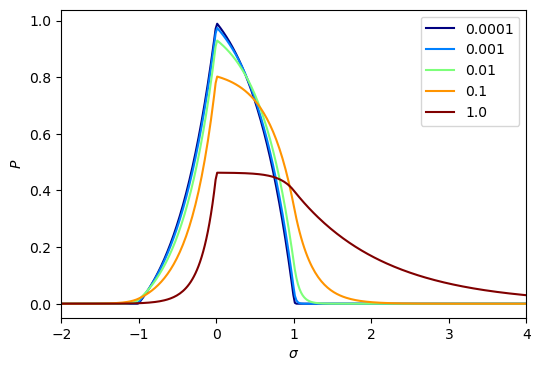

In [15]:
plt.figure(figsize=(6,4))
a = .4
for gd in [1.e-4, .001, .01, .1, 1.]:
    plot_solution(a, gd)
    
plt.xlim((-2,4))
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$P$')
plt.legend()
plt.show()
#plt.savefig('distrib_a4.pdf')

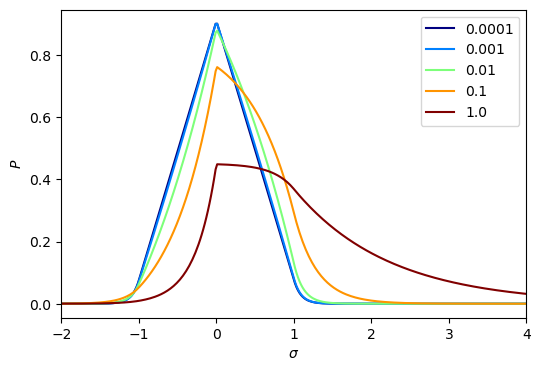

In [16]:
plt.figure(figsize=(6,4))
a = .6
for gd in [1.e-4, .001, .01, .1, 1.]:
    plot_solution(a, gd)

plt.xlim((-2,4))
plt.xlabel(r'$\sigma$')
plt.ylabel('$P$')
plt.legend()
plt.show()
#plt.savefig('distrib_a6.pdf')

We observe that:

- For $\alpha<\alpha_c$, the distribution remains asymmetric as $\dot\gamma\to 0$. This is expected since there is no solution that extends beyond $\sigma_c=1$ for $\dot\gamma=0$. As a consequence, the average stress should be positive: there is a nonzero stress as $\dot\gamma\to 0$, it is a yield stress fluid.
- For $\alpha>\alpha_c$, on the contrary, there is a solution for $\dot\gamma=0$ that extends beyond $\sigma_c$; this solution is the limit of the distribution as $\dot\gamma\to 0$. This distribution being symmetric, the average stress is 0 and the system flows for any value of the imposed stress.

To quantify this further, we plot below the flow curves $\langle\sigma\rangle(\dot\gamma)$ for different values of $\alpha$.

### Average stress as a function of the shear rate

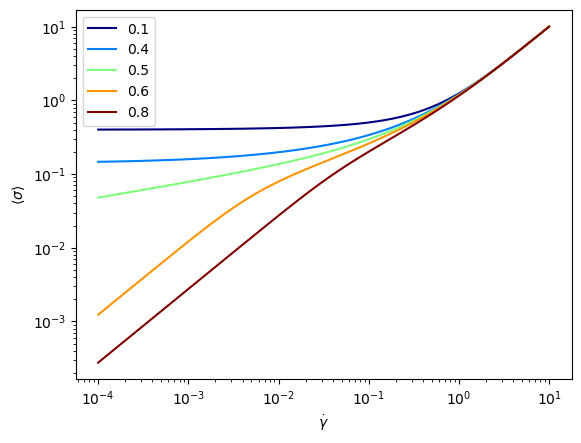

In [17]:
for a in [.1, .4, .5, .6, .8]:
    Gd = np.geomspace(1.e-4, 10)
    S  = [average_stress(a, gd, solution(a, gd)) for gd in Gd]
    plt.loglog(Gd, S, label=str(a))
    
plt.legend()
plt.xlabel(r"$\dot\gamma$")
plt.ylabel(r"$\langle\sigma\rangle$")
plt.show()
#plt.savefig('strain_stress.pdf')

We identify two behaviors for $\alpha<\alpha_c$ (yield stress fluid) and $\alpha>\alpha_c$ (shear-thinning fluid). For $\alpha=\alpha_c$, it we observe a power law $\langle\sigma\rangle\sim\dot\gamma^\beta$, with $0<\beta<1$.